# 05. Developmental Tree Inference

This notebook will introduce the usage of developmental tree inference with vector field. Note: The cell type transition is strictly constrained between adjecent time point

In [ ]:
import pygot
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
plt.rc('axes.spines', top=False, right=False)
%matplotlib inline

Here, we use the dataset of mouse embryogenesis (E0.5 to E6.5) collected from multiple studies. The processed adata file can be downloaded with https://figshare.com/ndownloader/files/54193955

In [2]:
adata = sc.read('../../pygot_data/development/E0_5_6_5/adata_processed.h5ad')

In [10]:
#Specify the temporal annotation, latent space
time_key = 'stage_numeric'
embedding_key = 'X_scVI'
velocity_key = 'velocity_scVI'

#Specify the cell type annotation
cell_type_key = 'cell_type'

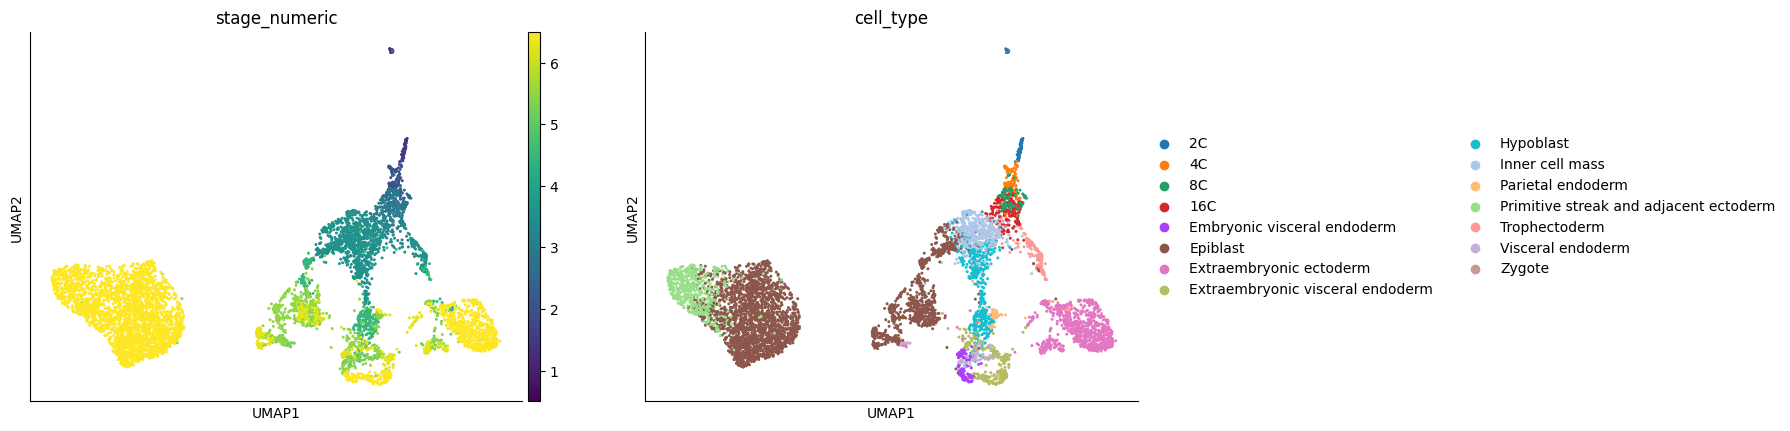

In [11]:
sc.pl.umap(adata, color=[time_key, cell_type_key])

In [22]:
#velocity model training
model, history = pygot.tl.traj.fit_velocity_model(adata, embedding_key=embedding_key, time_key=time_key, 
                                            x_centric_batch_size=128, v_centric_batch_size=128, 
                                            n_neighbors=30
                                           )

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0.5to1.5.pkl'
Error in loading shortest path file
calcu shortest path between 0.5 to 1.5


100%|███████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4995.53it/s]


calcu shortest path between 1.5 to 2.0


100%|███████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 4795.40it/s]

calcu shortest path between 2.0 to 2.5



100%|█████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 4436.85it/s]


calcu shortest path between 2.5 to 3.0


100%|█████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 3731.76it/s]


calcu shortest path between 3.0 to 3.25


100%|█████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 3945.72it/s]


calcu shortest path between 3.25 to 3.5


100%|███████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 1315.66it/s]


calcu shortest path between 3.5 to 4.5


100%|█████████████████████████████████████████████████████████████████████████████| 995/995 [00:00<00:00, 1301.22it/s]


calcu shortest path between 4.5 to 5.25


100%|█████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 2028.78it/s]


calcu shortest path between 5.25 to 5.5


100%|█████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 1858.75it/s]


calcu shortest path between 5.5 to 6.25


100%|█████████████████████████████████████████████████████████████████████████████| 464/464 [00:00<00:00, 1997.70it/s]


calcu shortest path between 6.25 to 6.5


loss :86.0482  best :86.0482: 100%|███████████████████████████████████████████████| 2000/2000 [02:05<00:00, 16.00it/s]


In [23]:
#Only require latent velocity
adata.obsm[velocity_key] = pygot.tl.traj.latent_velocity(adata, model, embedding_key=embedding_key, time_key=time_key)

## Developmental tree inference

In [24]:
roadmap = pygot.tl.analysis.TimeSeriesRoadmap(adata, embedding_key, velocity_key, time_key, sde=True)
roadmap.compute_state_coupling(cell_type_key=cell_type_key, n_neighbors=30)


2025-04-30 17:14:57 	 Compute transition roadmap among [0.5  1.5  2.   2.5  3.   3.25 3.5  4.5  5.25 5.5  6.25 6.5 ]
2025-04-30 17:14:57 	 Compute transition between 0.5 and 1.5
2025-04-30 17:14:57 	 Compute velocity graph
Scale factor: 7.0274467
Scale factor: 7.0274467
2025-04-30 17:14:57 	 Convert into markov chain
2025-04-30 17:14:57 	 Solve abosorbing probabilities
2025-04-30 17:14:57 	 Generate NULL distribution
2025-04-30 17:14:57 	 Compute transition between 1.5 and 2.0
2025-04-30 17:14:58 	 Compute velocity graph
Scale factor: 6.475193
Scale factor: 6.475193
2025-04-30 17:14:58 	 Convert into markov chain
2025-04-30 17:14:58 	 Solve abosorbing probabilities
2025-04-30 17:14:58 	 Generate NULL distribution
2025-04-30 17:14:58 	 Compute transition between 2.0 and 2.5
2025-04-30 17:14:58 	 Compute velocity graph
Scale factor: 3.922813
Scale factor: 3.922813
2025-04-30 17:14:58 	 Convert into markov chain
2025-04-30 17:14:58 	 Solve abosorbing probabilities
2025-04-30 17:14:58 	 Ge

Use permutation test to filter cell type coupling

In [25]:
filtered_back_state_coupling_list = roadmap.filter_state_coupling()

Plot cell type coupling in different stage 

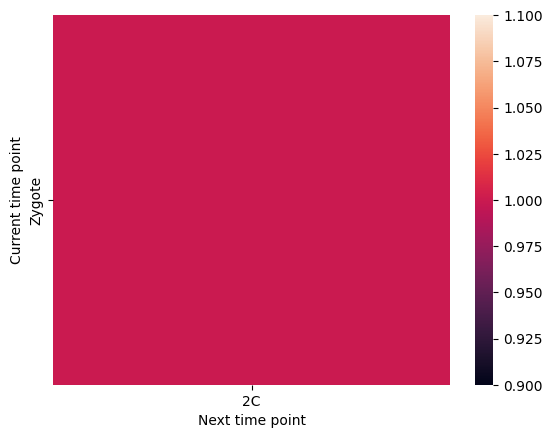

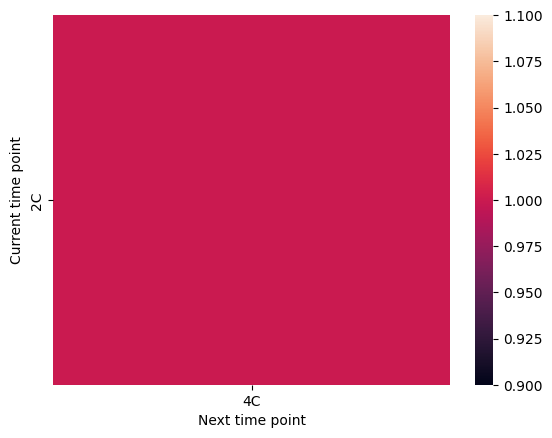

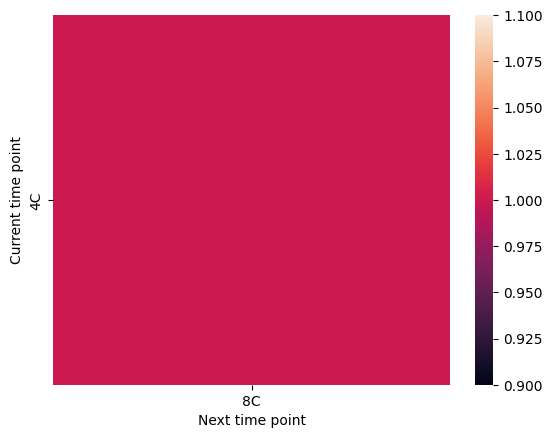

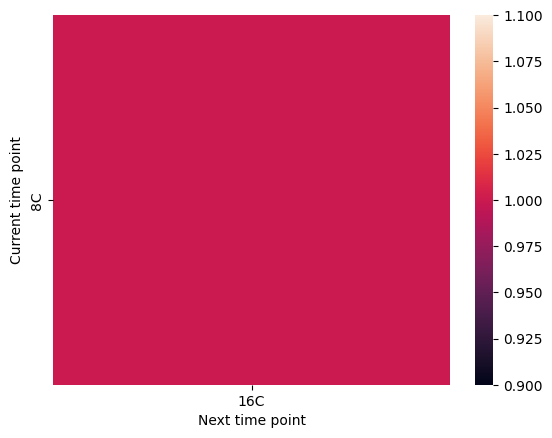

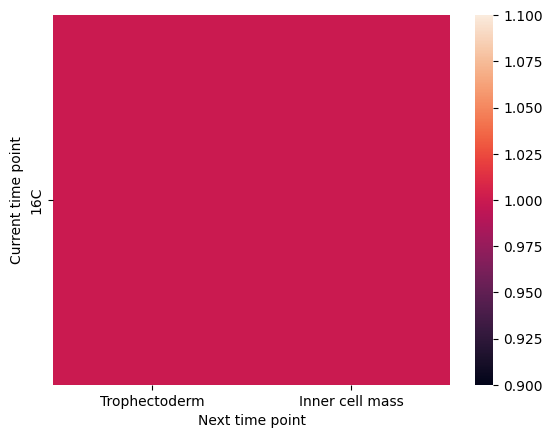

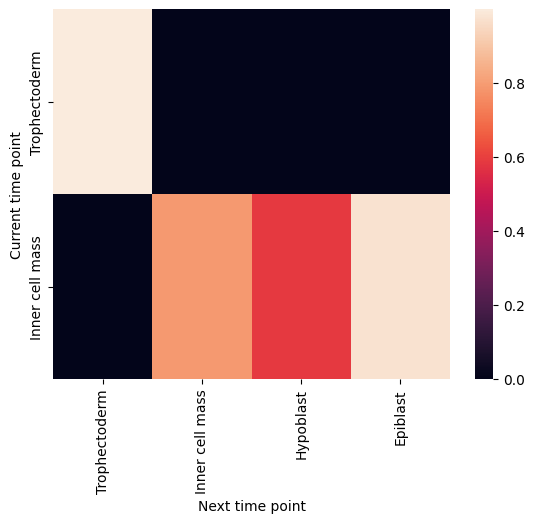

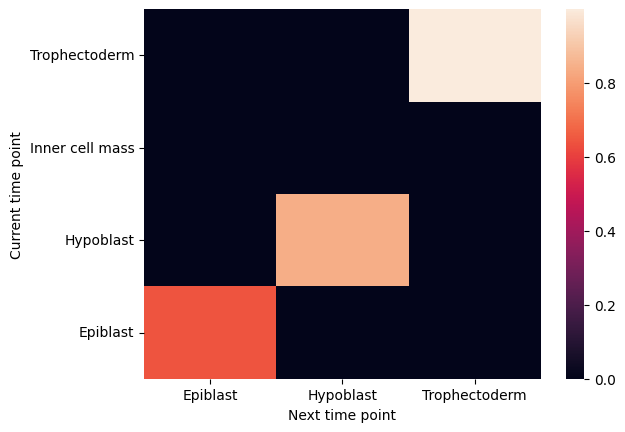

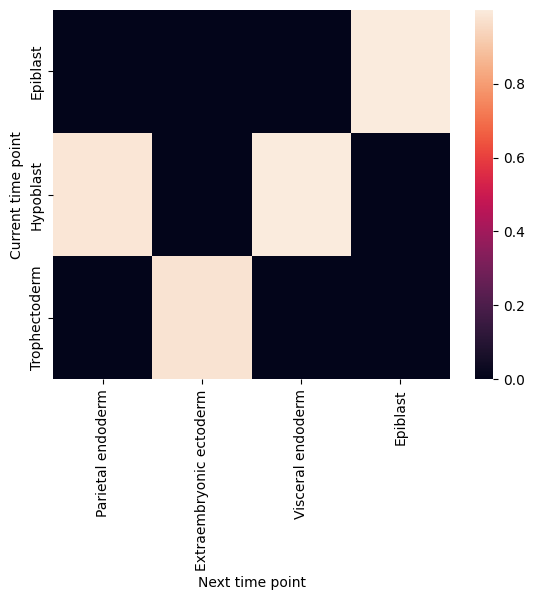

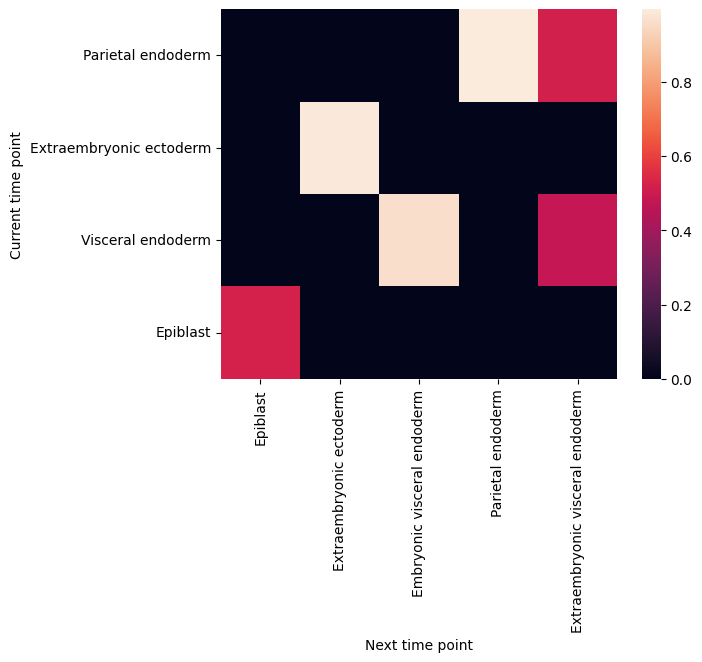

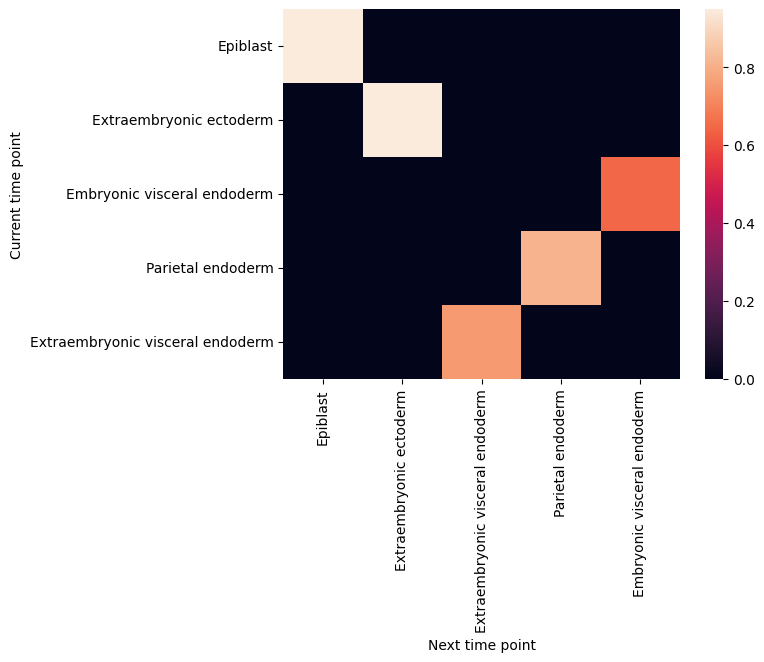

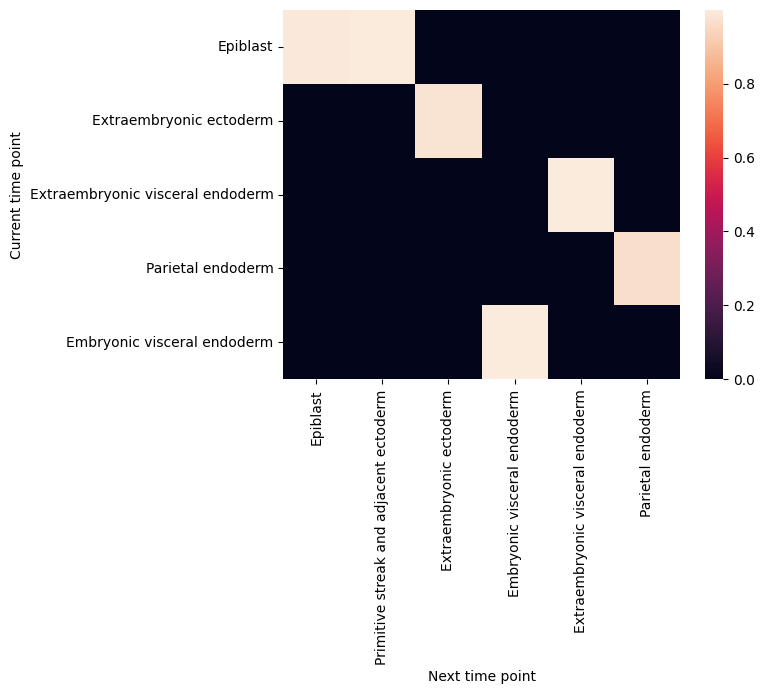

In [29]:
for df in filtered_back_state_coupling_list:
    sns.heatmap(df)
    plt.ylabel('Current time point')
    plt.xlabel('Next time point')
    plt.show()
    plt.close()